<a href="https://colab.research.google.com/github/pasdptt/PasdPublicNB/blob/master/Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Spark + import lib + start spark session


In [1]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bioni

In [2]:
#Get Install the Java Development Kit
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Get Spark lib -- address need to be change according to the current version of Spark: https://downloads.apache.org/spark/
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
#Unzip th Spark
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
#install findspark for Python
!pip install -q findspark
#Install extra lib(s)
!pip install -q xlrd
!pip install -q kaggle
!pip install -q kora

#import and set environment for spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

import kora
import pandas as pd

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *

SPARK_URL = "local[*]"

spark = SparkSession.builder.master(SPARK_URL).getOrCreate()

# Check the pyspark version
import pyspark
print(pyspark.__version__)

     |████████████████████████████████| 51kB 1.6MB/s 
3.0.1


In [3]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

%matplotlib inline

In [4]:
spark

#Getting Dataset

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#Adding API code here
!kaggle datasets download -d carrie1/ecommerce-data

Mounted at /content/gdrive
 83% 6.00M/7.20M [00:00<00:00, 62.9MB/s]
100% 7.20M/7.20M [00:00<00:00, 66.2MB/s]


In [6]:
!unzip /content/ecommerce-data.zip  && rm /content/ecommerce-data.zip

Archive:  /content/ecommerce-data.zip
  inflating: data.csv                


#Exploring Data

##About the dataset

In this article, we will use an e-commerce dataset which contains transactions for a UK-based and registered non-store online retail from 2010 to 2011 and is provided freely from The UCI Machine Learning Repository. You can download the data here.

The dataset contains the following relevant columns needed for our analysis:

* InvoiceNo. Unique id for each sale.
* StockCode. Unique id for each product.
* Quantity. Number of units bought.
* InvioceDate. Date of the sale.
* UnitPrice. Retail price of the product.
* CustomerID. Unique id for each customer.

In [7]:
data = spark.read.format("csv").option("header", "true").load("data.csv")

In [8]:
data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [10]:
data.count()

541909

In [12]:
data.agg(countDistinct("InvoiceNo")).show()

+----------------+
|count(InvoiceNo)|
+----------------+
|           25900|
+----------------+



##Check "Null"

In [9]:
from pyspark.sql.functions import isnan, when, count, col

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [13]:
data.describe().show()

+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|            541909|         541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|           null|4.611113626082972|15287.690570239585|       null|
| stddev|13428.417280800133| 16799.73762842775|                 NaN|218.08115785023486|           null| 96.7598530611797| 1713.600303321594|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|              

In [14]:
data.show()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

#Basic transformation

In [15]:
data = data.withColumn("Quantity", data["Quantity"].cast(IntegerType()))
data = data.withColumn("UnitPrice", data["UnitPrice"].cast(DoubleType()))

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
data = data.withColumn("Date", to_date(col("InvoiceDate"), "MM/dd/yyyy"))

# define Total column
data = data.withColumn("Total", round(data["UnitPrice"] * data["Quantity"], 2))

# calculate difference in days between 2011-12-31 and the Invoice Date
data = data.withColumn("RecencyDays", expr("datediff('2011-12-31', Date)"))

In [16]:
data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Total: double (nullable = true)
 |-- RecencyDays: integer (nullable = true)



In [17]:
data.show()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----------+-----+-----------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|      Date|Total|RecencyDays|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----------+-----+-----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-12-01| 15.3|        395|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01|20.34|        395|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-12-01| 22.0|        395|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-12-01|20.34|        395|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|

#Create RFM Table

Now that we have preprocessed our data, the creation of the RFM table is quite straightforward. For each customer, we need to measure the following indicators:
* Recency. We shall consider as recency the minimum RecencyDays that we calculated in the previous step. This makes sense since the minimum RecencyDays will give us the number of days that have passed since the customer’s last purchase.
* Frequency. It is calculated as the number of purchases that the customer has made.
* Monetary. It is the total value of all purchases for each customer.

In [18]:
rfm_table = data.groupBy("CustomerId")\
                        .agg(min("RecencyDays").alias("Recency"), \
                             count("InvoiceNo").alias("Frequency"), \
                             sum("Total").alias("Monetary"))

In [19]:
rfm_table.show()

+----------+-------+---------+------------------+
|CustomerId|Recency|Frequency|          Monetary|
+----------+-------+---------+------------------+
|     16250|    283|       24| 389.4400000000001|
|     15574|    199|      168| 702.2500000000001|
|     15555|     34|      925| 4758.199999999993|
|     15271|     29|      275|2485.8199999999997|
|     17714|    342|       10|             153.0|
|     17686|     29|      286| 5739.460000000005|
|     13865|     80|       30|501.55999999999995|
|     14157|     41|       49|400.43000000000006|
|     13610|     34|      228|1115.4299999999998|
|     13772|     55|      177|           1132.13|
|     13282|     40|       40|           1047.84|
|     12394|     85|       27|           1272.48|
|     16320|    194|       56|           1038.46|
|     13192|    117|       63|            911.94|
|     14887|    101|        6|            1862.0|
|     17506|     92|       16|294.28999999999996|
|     17427|     93|        2|             100.8|


Statisticly segmenting

In [21]:
r_quartile = rfm_table.approxQuantile("Recency", [0.25, 0.5, 0.75], 0)
f_quartile = rfm_table.approxQuantile("Frequency", [0.25, 0.5, 0.75], 0)
m_quartile = rfm_table.approxQuantile("Monetary", [0.25, 0.5, 0.75], 0)

rfm_table = rfm_table.withColumn("R_Quartile", \
                                 when(col("Recency") >= r_quartile[2] , 1).\
                                 when(col("Recency") >= r_quartile[1] , 2).\
                                 when(col("Recency") >= r_quartile[0] , 3).\
                                 otherwise(4))

rfm_table = rfm_table.withColumn("F_Quartile", \
                                 when(col("Frequency") > f_quartile[2] , 4).\
                                 when(col("Frequency") > f_quartile[1] , 3).\
                                 when(col("Frequency") > f_quartile[0] , 2).\
                                 otherwise(1))

rfm_table = rfm_table.withColumn("M_Quartile", \
                                 when(col("Monetary") >= m_quartile[2] , 4).\
                                 when(col("Monetary") >= m_quartile[1] , 3).\
                                 when(col("Monetary") >= m_quartile[0] , 2).\
                                 otherwise(1))

rfm_table = rfm_table.withColumn("RFM_Score", concat(col("R_Quartile"), col("F_Quartile"), col("M_Quartile")))


In [22]:
print(r_quartile)
print(f_quartile)
print(m_quartile)

[38.0, 72.0, 165.0]
[17.0, 42.0, 102.0]
[293.45, 648.4099999999999, 1612.1299999999999]


In [23]:
rfm_table.show()

+----------+-------+---------+------------------+----------+----------+----------+---------+
|CustomerId|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_Score|
+----------+-------+---------+------------------+----------+----------+----------+---------+
|     16250|    283|       24| 389.4400000000001|         1|         2|         2|      122|
|     15574|    199|      168| 702.2500000000001|         1|         4|         3|      143|
|     15555|     34|      925| 4758.199999999993|         4|         4|         4|      444|
|     15271|     29|      275|2485.8199999999997|         4|         4|         4|      444|
|     17714|    342|       10|             153.0|         1|         1|         1|      111|
|     17686|     29|      286| 5739.460000000005|         4|         4|         4|      444|
|     13865|     80|       30|501.55999999999995|         2|         2|         2|      222|
|     14157|     41|       49|400.43000000000006|         3|         3

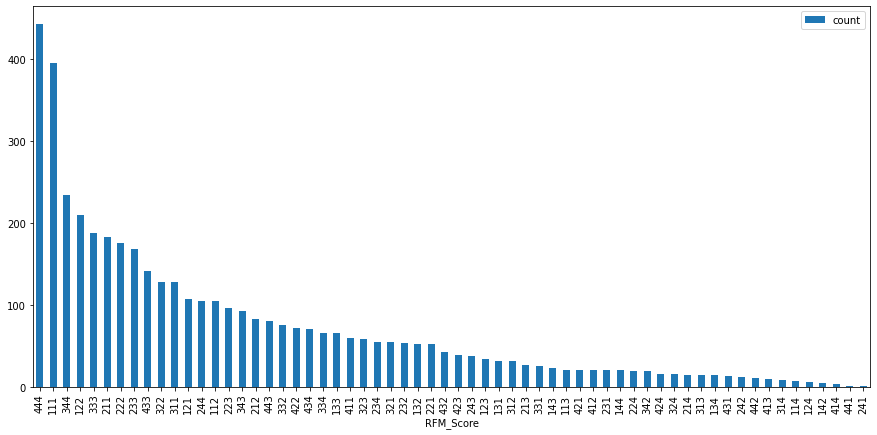

In [24]:
import plotly.graph_objs as go
import plotly.graph_objs as iplot


grouped_by_rfmscore = rfm_table.groupBy("RFM_Score").count().orderBy("count", ascending=False)
grouped_by_rfmscore_pandas = grouped_by_rfmscore.toPandas()

data2 = [go.Bar(x=grouped_by_rfmscore_pandas['RFM_Score'], y=grouped_by_rfmscore_pandas['count'])]

fig = grouped_by_rfmscore_pandas.plot(kind="bar",x='RFM_Score',figsize=(15,7))

#(kind="bar",figsize=(15,7))

In [ ]:
print(grouped_by_rfmscore_pandas)

   RFM_Score  count
0        444    442
1        111    395
2        344    234
3        122    210
4        333    187
..       ...    ...
57       124      6
58       142      4
59       414      3
60       441      1
61       241      1

[62 rows x 2 columns]


Surprisingly, the best customers compose the largest segment :), but ironically the worst customers (customers with all scores of 1s) are the second-largest segment :(.

Apart from the best and worst customers, we may also define the following important customer segments:
High-spending New Customers — This group consists of those customers in 4–1–3 and 4–1–4. These are customers who transacted only once, but very recently and they spent a lot.

Lowest-Spending Active Loyal Customers — This group consists of those customers in segments 3–4–1 and 4–4–1 (they transacted recently and do so often, but spend the least).

Churned Best Customers — This segment consists of those customers in groups 1–3–3, 1–4–3, 1–3–4 and 1–4–4 (they transacted frequently and spent a lot, but it’s been a long time since they’ve transacted).

In [25]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.



In [45]:
FEATURES_COL = ['Recency', 'Frequency', 'Monetary']

In [27]:
rfm_table.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|        CustomerId|           Recency|        Frequency|          Monetary|        R_Quartile|        F_Quartile|        M_Quartile|         RFM_Score|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|              4372|              4373|             4373|              4373|              4373|              4373|              4373|              4373|
|   mean|15299.677721866423|113.56025611708209|123.9215641436085|2229.0756757375143|2.4866224559798766|2.4877658358106562|2.5003430139492338| 276.0402469700434|
| stddev|1722.3907054276906|100.77013075625825|2054.469339333584| 23356.82678007669|1.1079092074312695|1.1192194656586396|1.1182640658287513|117.10355724341032|
|    min|             12346|      

In [28]:
r_outliner = rfm_table.approxQuantile("Recency", [0.005, 0.995], 0)
f_outliner = rfm_table.approxQuantile("Frequency", [0.005, 0.995], 0)
m_outliner = rfm_table.approxQuantile("Monetary", [0.005, 0.995], 0)

In [29]:
print(r_outliner)
print(f_outliner)
print(m_outliner)

[22.0, 394.0]
[1.0, 1061.0]
[-35.4, 33805.69000000002]


In [37]:
rfm_table.printSchema()

root
 |-- CustomerId: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: long (nullable = false)
 |-- Monetary: double (nullable = true)
 |-- R_Quartile: integer (nullable = false)
 |-- F_Quartile: integer (nullable = false)
 |-- M_Quartile: integer (nullable = false)
 |-- RFM_Score: string (nullable = false)



In [56]:
rfm_table_cleaned = rfm_table.filter((rfm_table.Monetary>=0.)).filter((rfm_table.Monetary<=3400.00))

In [43]:
rfm_table_cleaned.describe().show()

+-------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|        CustomerId|          Recency|        Frequency|         Monetary|        R_Quartile|       F_Quartile|       M_Quartile|         RFM_Score|
+-------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|              3868|             3868|             3868|             3868|              3868|             3868|             3868|              3868|
|   mean|15334.480093071355|119.8722854188211|61.30377456049638|841.0910522233706|2.3813340227507758| 2.34746639089969|2.338676318510858| 263.9467425025853|
| stddev|1707.2502473728584|101.0365862103314|75.78714436034097|770.6131058532251|1.0807256893543158|1.063658461459941|1.045924278208636|113.22212142132594|
|    min|             12346|               22|            

In [46]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(rfm_table_cleaned).select('CustomerId', 'features')
df_kmeans.show()

+----------+--------------------+
|CustomerId|            features|
+----------+--------------------+
|     16250|[283.0,24.0,389.4...|
|     15574|[199.0,168.0,702....|
|     15271|[29.0,275.0,2485....|
|     17714|  [342.0,10.0,153.0]|
|     13865|[80.0,30.0,501.55...|
|     14157|[41.0,49.0,400.43...|
|     13610|[34.0,228.0,1115....|
|     13772|[55.0,177.0,1132.13]|
|     13282| [40.0,40.0,1047.84]|
|     12394| [85.0,27.0,1272.48]|
|     16320|[194.0,56.0,1038.46]|
|     13192| [117.0,63.0,911.94]|
|     14887|  [101.0,6.0,1862.0]|
|     17506|[92.0,16.0,294.28...|
|     17427|    [93.0,2.0,100.8]|
|     18130|[30.0,71.0,1045.7...|
|     16504|[47.0,86.0,484.37...|
|     15269|    [45.0,2.0,408.8]|
|     12847|[44.0,91.0,871.53...|
|     15634|  [39.0,15.0,243.55]|
+----------+--------------------+
only showing top 20 rows



In [47]:
from pyspark.ml.evaluation import *

cost = list()
evaluator = ClusteringEvaluator()
for k in range(2,10):
    bkm = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    bkm_model = bkm.fit(df_kmeans.sample(False,0.1, seed=42))
    tags_predictions = bkm_model.transform(df_kmeans.sample(False,0.1, seed=42))
    silhouette = evaluator.evaluate(tags_predictions)
    cost.append(silhouette)
    
kIdx = np.argmax(cost)

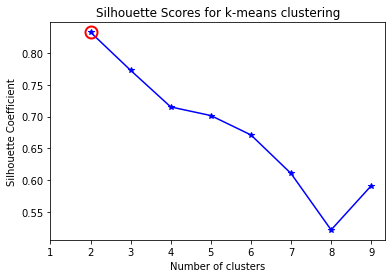

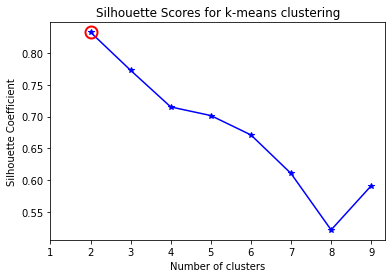

In [49]:
fig, ax = plt.subplots()
plt.plot(range(2,10), cost, 'b*-')
plt.plot(range(2,10)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
# Uncomment the next line
display(fig)

In [62]:
k = 3
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[  61.48109244  165.70588235 2494.07743697]
[146.66419448  30.80758138 358.0620478 ]
[  81.29222798   86.50466321 1240.56242487]


In [63]:
transformed = model.transform(df_kmeans).select('CustomerId', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(CustomerId='16250', prediction=1), Row(CustomerId='15574', prediction=1), Row(CustomerId='15271', prediction=0)]


In [64]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+----------+----------+
|CustomerId|prediction|
+----------+----------+
|     16250|         1|
|     15574|         1|
|     15271|         0|
|     17714|         1|
|     13865|         1|
|     14157|         1|
|     13610|         2|
|     13772|         2|
|     13282|         2|
|     12394|         2|
|     16320|         2|
|     13192|         2|
|     14887|         2|
|     17506|         1|
|     17427|         1|
|     18130|         2|
|     16504|         1|
|     15269|         1|
|     12847|         2|
|     15634|         1|
+----------+----------+
only showing top 20 rows



In [65]:
df_pred = df_pred.join(rfm_table_cleaned, 'CustomerId')
df_pred.show()

+----------+----------+-------+---------+------------------+----------+----------+----------+---------+
|CustomerId|prediction|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_Score|
+----------+----------+-------+---------+------------------+----------+----------+----------+---------+
|     12394|         2|     85|       27|           1272.48|         2|         2|         3|      223|
|     12847|         2|     44|       91| 871.5399999999998|         3|         3|         3|      333|
|     13192|         2|    117|       63|            911.94|         2|         3|         3|      233|
|     13282|         2|     40|       40|           1047.84|         3|         2|         3|      323|
|     13610|         2|     34|      228|1115.4299999999998|         4|         4|         3|      443|
|     13772|         2|     55|      177|           1132.13|         3|         4|         3|      343|
|     13865|         1|     80|       30|501.55999999999995|    

In [66]:
df_pred2=df_pred.select("CustomerId","prediction","Recency","Frequency","Monetary")

In [67]:
pddf_pred = df_pred2.toPandas().set_index('CustomerId')
pddf_pred.head()

,prediction,Recency,Frequency,Monetary
CustomerId,,,,
12394,2,85,27,1272.48
12847,2,44,91,871.54
13192,2,117,63,911.94
13282,2,40,40,1047.84
13610,2,34,228,1115.43


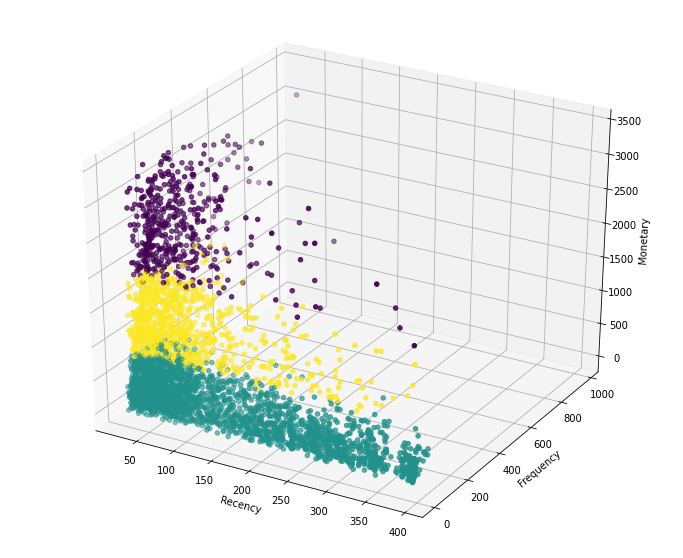

In [68]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.Recency, pddf_pred.Frequency, pddf_pred.Monetary, c=pddf_pred.prediction)
threedee.set_xlabel('Recency')
threedee.set_ylabel('Frequency')
threedee.set_zlabel('Monetary')
plt.show()